# NLP & ML Final Project - Text-Independent Speaker Verification,  Deep Speaker article implementation

Please run on GPU, additional RAM maybe also required (colab has 25Gb RAM model) (but ordinary settings should also work)

## Downloaing pretrained networks and datasets

In [63]:
!pip install gdown

In [64]:
!gdown https://drive.google.com/uc?id=1BpROORisLEgIPOXZ232RetM2iuKLzvMF

Downloading...
From: https://drive.google.com/uc?id=1BpROORisLEgIPOXZ232RetM2iuKLzvMF
To: /content/my_dataset2.pt
2.96GB [00:19, 153MB/s] 


In [65]:
!gdown https://drive.google.com/uc?id=1i8lH6-ANGlkE-n5at7_VqcWqL_CatWsD

Downloading...
From: https://drive.google.com/uc?id=1i8lH6-ANGlkE-n5at7_VqcWqL_CatWsD
To: /content/evaluate_files.zip
343MB [00:03, 112MB/s]


In [66]:
!gdown https://drive.google.com/uc?id=1WfI5INQFDXjkXzZ3l-rBKsrCr0bzcQYp

Downloading...
From: https://drive.google.com/uc?id=1WfI5INQFDXjkXzZ3l-rBKsrCr0bzcQYp
To: /content/updated_path_correct_76566.csv
2.68MB [00:00, 86.1MB/s]


In [67]:
!unzip evaluate_files.zip

Archive:  evaluate_files.zip
replace evaluate_files/lavrikov_ru_0001.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [68]:
!gdown https://drive.google.com/uc?id=1-69qRo62y-KSQ3mhykpR9mvRwUkGqp7p

Downloading...
From: https://drive.google.com/uc?id=1-69qRo62y-KSQ3mhykpR9mvRwUkGqp7p
To: /content/deepspeaker_triplet_checkpoints10.zip
1.16GB [00:10, 104MB/s] Exception KeyboardInterrupt: KeyboardInterrupt() in <generator object read_chunked at 0x7fba79fd10a0> ignored
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/gdown/cli.py", line 61, in main
    quiet=args.quiet,
  File "/usr/local/lib/python2.7/dist-packages/gdown/download.py", line 102, in download
    f.write(chunk)
KeyboardInterrupt
1.16GB [00:10, 114MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1yePDt9-D3Ph1pQ54j6PGsU_rfLeQj-qI

Downloading...
From: https://drive.google.com/uc?id=1yePDt9-D3Ph1pQ54j6PGsU_rfLeQj-qI
To: /content/deepspeaker_soft_checkpoints3.zip
1.24GB [00:09, 145MB/s]

In [ ]:
!unzip deepspeaker_triplet_checkpoints10.zip

In [ ]:
!unzip deepspeaker_soft_checkpoints3.zip

In [ ]:
! pip install python_speech_features

In [ ]:
! pip install soundfile

In [1]:
import torch
from random import choice
import numpy as np
import pandas as pd
from torch import nn
from soundfile import read
from python_speech_features import fbank
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.notebook import tqdm
import random
import librosa 
import os 
import matplotlib.pyplot as plt

In [3]:
#DEFINE CONSTANTS
# taken from https://github.com/philipperemy/deep-speaker/blob/master/conv_models.py
# In the article, section 4.3: 'Audio is converted to 64-dimensional Fbank coefficients, 
# normalized to have zero mean and unit variance.'
NUM_FBANKS = 32
NUM_FRAMES = 64

## DEFINE MODEL

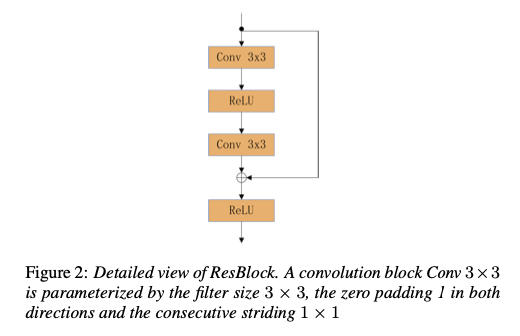

In [4]:
class ResBlock(nn.Module):
  def __init__(self, filters, stride=1):
    super().__init__()
    self.features1 = nn.Sequential(
        nn.Conv2d(filters, filters, kernel_size=3, stride=stride,
                     padding=1, bias=False),
        nn.BatchNorm2d(filters),
        nn.Hardtanh(min_val=0, max_val=20),
        nn.Conv2d(filters, filters, kernel_size=3, stride=stride,
                        padding=1, bias=False),
        nn.BatchNorm2d(filters),
    )
    self.features2 = nn.Hardtanh(min_val=0, max_val=20)

  def forward(self, x):
    o = self.features1(x)
    return self.features2(o + x)

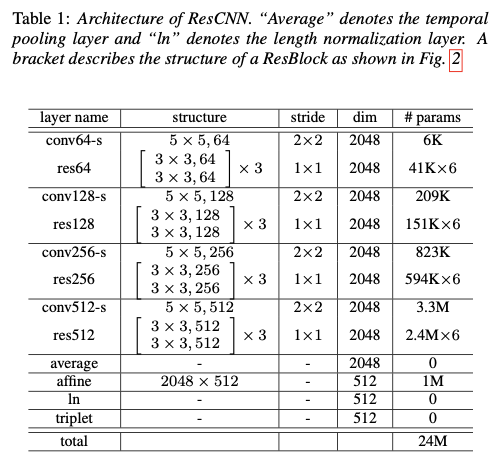

In [5]:
class StageBlock(nn.Module):
  def __init__(self, filters_in, filters, stride=2):
    super().__init__()
    self.conv = nn.Conv2d(filters_in, filters, kernel_size=5, stride=stride, 
                          padding=2,bias=False)
    self.norm = nn.BatchNorm2d(filters)
    self.res_block1 = ResBlock(filters)
    self.res_block2 = ResBlock(filters)
    self.res_block3 = ResBlock(filters)
  
  def forward(self, x):
    aft_conv = self.conv(x) 
    aft_norm = self.norm(aft_conv)
    res1 = self.res_block1(aft_norm)
    res2 = self.res_block2(res1)
    res3 = self.res_block3(res2)
    return res3

In [6]:
class DeepSpeaker(nn.Module):
  def __init__(self, **kwargs):
    super().__init__()
    NUM_FRAMES = 160
    NUM_FBANKS = 64
    # self.batch_input_shape = kwargs.get('batch_input_shape', (None, NUM_FBANKS, NUM_FRAMES, 1))
    self.include_softmax = kwargs.get('include_softmax', False)
    self.num_speakers_softmax = kwargs.get('num_speakers_softmax', None)
    if self.include_softmax:
      assert self.num_speakers_softmax > 0

    self.stage1 = StageBlock(filters_in=1, filters=64)
    self.stage2 = StageBlock(filters_in=64, filters=128)
    self.stage3 = StageBlock(filters_in=128, filters=256)
    self.stage4 = StageBlock(filters_in=256, filters=512)
    self.avgpool = nn.AdaptiveAvgPool2d((1,None))
    self.fc = nn.Linear(2048, 512)
    if self.include_softmax:
      self.classifier = nn.Linear(512,  self.num_speakers_softmax)

  def l2_norm(self, input):
    input_size = input.size()
    norm = torch.sqrt(torch.sum(torch.pow(input, 2), 1).add_(1e-10))
    _output = torch.div(input, norm.view(-1, 1).expand_as(input))
    output = _output.view(input_size)
    return output 

  def forward(self, x):
    res1 = self.stage1(x)
    res2 = self.stage2(res1)
    res3 = self.stage3(res2)
    res4 = self.stage4(res3)
    avg = self.avgpool(res4)
    reshaped = avg.view(avg.size(0), -1)
    affine = self.fc(reshaped)
    ln = self.l2_norm(affine)
    if self.include_softmax:
      ln = self.classifier(ln)
    return ln

## DEFINE AUDIO PREPROCESSING

In [7]:
# our data is store in .ogg format and all scaled to same samplle rate = 16000
SAMPLE_RATE = 16_000
NUM_FBANKS= 64
EPSILON = 1e-12
path ='/content/drive/My Drive/Initial Dataset/cv-corpus-5.1-2020-06-22/ru/clips/'


def extract_mfcc(input_filename):
  try:
    audio, _ = read(input_filename)
    # transform 2 channel record into a mono one
    audio = (audio[:, 0]+audio[:, 1])/2
    # remove start and end silence
    silence_threshold = np.percentile(np.abs(audio), 95)
    start = np.where(np.abs(audio) > silence_threshold)[0][0]
    end = np.where(np.abs(audio) > silence_threshold)[0][-1]
    # extract mfcc
    filter_banks, _ = fbank(audio[start:end], samplerate=SAMPLE_RATE, nfilt=NUM_FBANKS)
    filter_banks = [(v - np.mean(v)) / max(np.std(v), EPSILON) for v in filter_banks]
    return np.array(filter_banks)
  except:
    return []

## DEFINE DATASET AND DATALOADER

In [8]:
id_path = pd.read_csv('/content/updated_path_correct_76566.csv')
id_path= id_path.rename({'A':'id', 'B':'path'}, axis='columns')

In [9]:
id_path.head()

,id,path
0,0,2-common_voice_ru_18935950.ogg
1,0,2-common_voice_ru_18935952.ogg
2,0,2-common_voice_ru_18935951.ogg
3,0,2-common_voice_ru_18935953.ogg
4,0,2-common_voice_ru_18935954.ogg


In [10]:
def sample_from_mfcc(mfcc, max_length):
    if mfcc.shape[0] >= max_length:
        r = choice(range(0, len(mfcc) - max_length + 1))
        s = mfcc[r:r + max_length]
    else:
        s = np.vstack((mfcc, np.tile(np.zeros(mfcc.shape[1]), (max_length - len(mfcc), 1))))
    return s


def help_create_dataset(max_length = 160):
  xs = []
  ys = []
  for _, row in tqdm(id_path.iterrows()):
    x_cur = extract_mfcc(f'{path}{row["path"]}')
    if x_cur != []:
      if x_cur.shape[0] >= max_length - 40:
        ys.append(row['id'])
        x_cur = sample_from_mfcc(x_cur, max_length)
        xs.append(x_cur)  
    else:
      print(f'{row["path"]} FAILED')

  print('iterating is finished')
  xs = torch.tensor(xs, dtype=torch.float32)  
  ys = torch.tensor(ys, dtype=torch.long)

  return TensorDataset(xs, ys)

## TRAINING

In [11]:
# https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
# from the article, section 4.3 "he margin α is set to 0.1"
triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function=nn.CosineSimilarity(), margin = 0.1)

* "Deep Speaker models are trained in two stages: softmax pre-training and triplet loss fine-tuning. ... The model is pre-trained for 10 epochs with a minibatch size of 64 and fine-tuned with triplet loss for 15 epochs using a minibatch size of 128. "
* "In both stages, we use synchronous SGD with 0.99 momentum"
* "a linear decreasing learning rate schedule from 0.05 to 0.005."

In [12]:
SOFTMAX_EPOCHS = 10
TRIPLET_EPOCHS = 15
SOFTMAX_BATCH = 64
TRIPLET_BATCH = 128

In [ ]:
# this may fail or keep a couple of hours due to big amount of files
# for me it has taken 10 hours with files from drive
# my_dataset1 = help_create_dataset()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


Buffered data was truncated after reaching the output size limit.

In [ ]:
# torch.save(my_dataset1, 'my_dataset2.pt')

In [27]:
my_dataset1 = torch.load('/content/my_dataset2.pt')

In [28]:
!mkdir deepspeaker_soft_checkpoints

In [29]:
dl = DataLoader(my_dataset1, shuffle=True, batch_size=SOFTMAX_BATCH)

In [ ]:
# dl -> (BATCH_SIZE, 160, 64)
# model <- (BATCH_SIZE, 1, 160, 64)

In [30]:
# adapted from https://github.com/pollytur/Introduction-To-Computer-Vision-Course/blob/master/crack%20detection%20assigment/Assigment2_CrackDetection-2.ipynb
# note, that it's my repo

def train_loop_softmax(dl, model, saving_name):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)
  model.to(device)

  # note that alpha is big 
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05,  momentum=0.99)
  losses = []
  minibatch_losses = []
  criterion1 = nn.CrossEntropyLoss()
  lambda1 = lambda epoch: 0.05 - epoch * (0.05 - 0.005) / SOFTMAX_EPOCHS
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])

  for epoch in range(SOFTMAX_EPOCHS):
    
    loss = 0.0
    model.train()
    minibatch_counter = 0
    
    for x, y in tqdm(dl):
        x = x.to(device)
        y = y.to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        x = torch.unsqueeze(x, 1)
        # compute reconstructions
        outputs = model(x)
        # compute training reconstruction loss
        train_loss = criterion1(outputs, y)
          
        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        item = train_loss.item()
        loss += item
        minibatch_losses.append(item)
        minibatch_counter += 1
      
    # compute the epoch training loss
    loss = loss / minibatch_counter # loss per batch
    losses.append(item)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, SOFTMAX_EPOCHS, loss))
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, f"{saving_name}_{epoch}.pt")
    scheduler.step()
  
  return minibatch_losses, losses

In [ ]:
model = DeepSpeaker(include_softmax=True, 
                    num_speakers_softmax=len(list(set(list(id_path['id'])))))
minibatch_losses1, losses1 = train_loop_softmax(dl, model, saving_name='deepspeaker_soft_checkpoints/soft_deepspeaker')

cuda



epoch : 1/10, loss = 4.427559



epoch : 2/10, loss = 2.801809



epoch : 3/10, loss = 2.316907



epoch : 4/10, loss = 2.088216



epoch : 5/10, loss = 1.935706



epoch : 6/10, loss = 1.828851



epoch : 7/10, loss = 1.752153



epoch : 8/10, loss = 1.690251



epoch : 9/10, loss = 1.645563



epoch : 10/10, loss = 1.613907


In [31]:
from collections import Counter

ys = [int(i[1]) for i in my_dataset1]
ys_ar = np.asarray(ys)
ys_count = dict(Counter(ys))
l = len(ys_ar)

def get_positive(x, y):
  if ys_count[int(y)] == 1:
    return x
  else:
    indexes = np.where(ys_ar == int(y))[0]
    ind = np.random.choice(indexes)
    while torch.all(torch.eq(my_dataset1[ind][0], x)):
      ind = np.random.choice(indexes)

    return my_dataset1[ind][0].numpy()



def get_negative(x, y):
  indexes = np.where(ys_ar == int(y))[0]
  minim = indexes[0] 
  maxim = indexes[-1]
  ind = np.random.choice(np.concatenate((np.arange(minim), np.arange(maxim + 1, l)), axis=0))
  return my_dataset1[ind][0].numpy()

In [32]:
def train_loop_triplet(dl, model, saving_name, epochs = TRIPLET_EPOCHS):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  # note that alpha is different from the article and no scheduler 
  optimizer = torch.optim.SGD(model.parameters(), lr=0.0001,  momentum=0.99)
  losses = []
  minibatch_losses = []
  criterion2 = triplet_loss
  for epoch in range(TRIPLET_EPOCHS):
    
    loss = 0.0
    model.train()
    minibatch_counter = 0
    
    for x, y in tqdm(dl):
      try:
        y = y.numpy()
        x_pos = torch.tensor([get_positive(x[idx], y[idx]) for idx in range(y.shape[0])])
        x_neg = torch.tensor([get_negative(x[idx], y[idx]) for idx in range(y.shape[0])])
        x_pos = x_pos.to(device)
        x_neg = x_neg.to(device)
        x = x.to(device)
      except:
        continue
        
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
      optimizer.zero_grad()
      x = torch.unsqueeze(x, 1)
      x_pos = torch.unsqueeze(x_pos, 1)
      x_neg = torch.unsqueeze(x_neg, 1)
      # compute reconstructions
      outputs = model(x)
      outputs_pos = model(x_pos)
      outputs_neg = model(x_neg)

      # compute training reconstruction loss 
      # anchor, positive, negative
      train_loss = criterion2(outputs, outputs_pos, outputs_neg)          
      # compute accumulated gradients
      train_loss.backward()

      # perform parameter update based on current gradients
      optimizer.step()

      # add the mini-batch training loss to epoch loss
      item = train_loss.item()
      loss += item
      minibatch_losses.append(item)
      minibatch_counter += 1
        
    # compute the epoch training loss
    loss = loss / minibatch_counter # loss per batch
    losses.append(item)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch, epochs, loss))
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, f"{saving_name}_{epoch}.pt")
  
  return minibatch_losses, losses

In [33]:
!mkdir deepspeaker_triplet_checkpoints

In [34]:
model_without_softmax = DeepSpeaker(include_softmax=True, 
                    num_speakers_softmax=len(list(set(list(id_path['id'])))))
model_without_softmax.load_state_dict(
    torch.load('deepspeaker_soft_checkpoints3/soft_deepspeaker_9.pt')['model_state_dict'])
model_without_softmax.include_softmax = False

In [ ]:
dl_triplet = DataLoader(my_dataset1, shuffle=True, batch_size=TRIPLET_BATCH)

minibatch_losses2, losses2 = train_loop_triplet(dl_triplet, 
                                                model_without_softmax, 
                                                saving_name = 'deepspeaker_triplet_checkpoints/triplet_deepspeaker' )


epoch : 0/15, loss = 0.356910



epoch : 1/15, loss = 0.102691



epoch : 2/15, loss = 0.102017



epoch : 3/15, loss = 0.101654



epoch : 4/15, loss = 0.101410



epoch : 5/15, loss = 0.101233



epoch : 6/15, loss = 0.101101



epoch : 7/15, loss = 0.100988



epoch : 8/15, loss = 0.100901



epoch : 9/15, loss = 0.100832



epoch : 10/15, loss = 0.100768



epoch : 11/15, loss = 0.100718



epoch : 12/15, loss = 0.100672



epoch : 13/15, loss = 0.100635



epoch : 14/15, loss = 0.100596


0.1 in loss is defined by margin we added (0.1)

## METRICS EVALUATION

For metric evaluation we will use VoxForge Dataset. There are 207 speakers in it, for each of them I have keeped 3 records -> 621 records. We will filer data a bit because some of 'unique speakers' are not unique and there were speakers from different people with one lable. This is the problem of initial dataset.

### Preparing dataset

In [13]:
files = os.listdir('evaluate_files/')
unique_speakers = list(set([i[:-12] for i in files]))
same = ['NazarovM','Nazarov','MaratNazarov', 'Marat']
drop = ['rdc_An','rdc_Rosenberg', 'rdc_Yankov'] + same

speakers_ids = dict()
for i, v in enumerate(unique_speakers):
  speakers_ids[v] = i

test_df = pd.DataFrame(columns=['name', 'filename', 'person_id'])
for f in files:
  if f[:-12] not in drop:
    test_df = test_df.append({'name':f[:-12], 'filename':f, 'person_id':speakers_ids[f[:-12]]}, ignore_index=True)

In [14]:
test_df

,name,filename,person_id
0,hawk,hawk_ru_0094.wav,151
1,ira_ira,ira_ira_ru_0486.wav,23
2,Lysyy,Lysyy_ru_0078.wav,72
3,len_len,len_len_ru_0321.wav,171
4,Tellef,Tellef_ru_0032.wav,146
...,...,...,...
601,dims,dims_ru_0015.wav,50
602,Strannik,Strannik_ru_0036.wav,38
603,EvilDmitri,EvilDmitri_ru_0003.wav,148
604,Lysyy,Lysyy_ru_0082.wav,72


In [15]:
from scipy.io.wavfile import read
 

def extract_mfcc_wav(input_filename):
  try:
    # librosa downsample initial sample frrequency from 48000 -> 16000
    audio, sr = librosa.load(input_filename, sr=16000)
    silence_threshold = np.percentile(np.abs(audio), 95)
    start = np.where(np.abs(audio) > silence_threshold)[0][0]
    end = np.where(np.abs(audio) > silence_threshold)[0][-1]
    # extract mfcc
    filter_banks, _ = fbank(audio[start:end], samplerate=SAMPLE_RATE, nfilt=NUM_FBANKS)
    filter_banks = [(v - np.mean(v)) / max(np.std(v), EPSILON) for v in filter_banks]
    return np.array(filter_banks)
  except:
    return []

### Evaluation

In [24]:
def batch_cosine_similarity(x1, x2):
    # 1 = equal direction ; -1 = opposite direction
    # embeddings are normed => no need to divide by norm
    return np.sum(np.multiply(x1, x2))


def evaluate(sims, labels):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 1.0, 0.001)
    tpr, fpr, acc = calculate_roc(thresholds, sims, labels)
    eer = calculate_eer(thresholds, sims, labels)
    return tpr, fpr, acc, eer


def calculate_roc(thresholds, sims, labels):
    tprs = [0] * len(thresholds)
    fprs = [0] * len(thresholds)
    acc_train = [0] * len(thresholds)
    fms = np.zeros((len(thresholds)))
    accuracy = 0.0
    for threshold_idx, threshold in enumerate(thresholds):
        tprs[threshold_idx], fprs[threshold_idx], acc_train[threshold_idx], \
        fms[threshold_idx] = calculate_accuracy(threshold, sims, labels)

    bestindex = np.argmax(fms)
    besttpr = tprs[bestindex]
    bestfpr = fprs[bestindex]
    bestacc = acc_train[bestindex]
 
    return besttpr, bestfpr, bestacc


def calculate_accuracy(threshold, sims, actual_issame):
    predict_issame = np.greater(sims, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / len(sims)
    precision = 0 if (tp + fp == 0) else float(tp) / float(tp + fp)
    fm = 2 * precision * tpr / (precision + tpr + 1e-12)
    # tpr, fpr, precision, fm, acc
    return tpr, fpr, acc, fm


def calculate_eer(thresholds, sims, labels):
    # Find the threshold that gives FAR = far_target
    far_train = [0] * len(thresholds)
    frr_train = [0] * len(thresholds)
    eer_index = 0
    eer_diff = 100000000
    for threshold_idx, threshold in enumerate(thresholds):
        frr_train[threshold_idx], far_train[threshold_idx] = calculate_val_far(threshold, sims, labels)
        if abs(frr_train[threshold_idx] - far_train[threshold_idx]) < eer_diff:
            eer_diff = abs(frr_train[threshold_idx] - far_train[threshold_idx])
            eer_index = threshold_idx

    return (frr_train[eer_index] + far_train[eer_index]) / 2


def calculate_val_far(threshold, sims, actual_issame):
    if np.sum(actual_issame) == 0:
        return 0, 0
    n_diff = 1 if (np.sum(np.logical_not(actual_issame)) == 0) else np.sum(np.logical_not(actual_issame))
    predict_issame = np.greater(sims, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    val = float(true_accept) / float(np.sum(actual_issame))
    # frr and far
    return (1 - val), float(false_accept) / float(n_diff)


def get_tprs_and_frps(thresholds, sims, labels):
  tprs = [0] * len(thresholds)
  fprs = [0] * len(thresholds)
  for idx, threshold in enumerate(thresholds):
    tprs[idx], fprs[idx], _, _ = calculate_accuracy(threshold, sims, labels)
  return (tprs, fprs)

In [17]:
model_to_evaluate = DeepSpeaker(include_softmax=True, 
                    num_speakers_softmax=len(list(set(list(id_path['id'])))))
model_to_evaluate.load_state_dict(
    torch.load('/content/deepspeaker_triplet_checkpoints10/triplet_deepspeaker_0.pt')['model_state_dict'])
model_to_evaluate.include_softmax = False

In [18]:
import warnings
warnings.filterwarnings("ignore")

d_vectors = []
d_vect_ids = []
max_length = 160
path = '/content/evaluate_files/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_to_evaluate.to(device)
with torch.no_grad():
  for ind, row in tqdm(test_df.iterrows()):
    x_cur = extract_mfcc_wav(f'{path}{row["filename"]}')
    if x_cur != []:
      if x_cur.shape[0] >= max_length - 40:
        file_to_test = sample_from_mfcc(x_cur, max_length)
        file_to_test = torch.tensor(file_to_test, dtype=torch.float32)
        file_to_test = file_to_test.view(1, 1, 160, 64).cuda()
        d_vectors.append(model_to_evaluate(file_to_test).detach().cpu().numpy())
        d_vect_ids.append(row['person_id'])

In [25]:
tprs_sum = []
fprs_sum = []

acc_sum = 0
eer_sum = 0

for ind, j in tqdm(enumerate(d_vectors)):
  y_pred = [batch_cosine_similarity(j, i) for i in d_vectors]

  y_true = [0]* len(d_vectors)
  for i in range(len(d_vectors)):
    if d_vect_ids[ind] == d_vect_ids[i]:
      y_true[i] = 1.0

  tprs, fprs = get_tprs_and_frps(np.arange(0, 1, 0.001), y_pred, y_true)

  _, _, acc, eer = evaluate(y_pred, y_true)
  acc_sum += acc
  eer_sum += eer

  tprs_sum.append(tprs)
  fprs_sum.append(fprs)

print(f'Accuracy {acc_sum/len(d_vectors)}, EER {eer_sum/len(d_vectors)}')


Accuracy 0.9449247934467883, EER 0.06732808284427666


Text(0.5, 1.0, 'True/False Positive rates tradeoff')

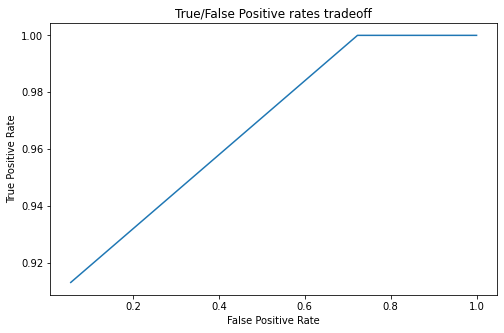

In [26]:
tprs_res = np.mean(np.array(tprs_sum), axis=0)
fprs_res = np.mean(np.array(fprs_sum), axis=0)
plt.figure(figsize=(8,5))
plt.plot(fprs_res, tprs_res)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('True/False Positive rates tradeoff')